In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Import libraries
from __future__ import division

import pandas as pd
import matplotlib.pyplot as plt  # plotting
import numpy as np  # linear algebra
import math

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    RepeatedStratifiedKFold,
    StratifiedKFold,
)

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    auc,
    precision_score,
    recall_score,
    precision_recall_curve,
    plot_confusion_matrix,
    f1_score,
)


from collections import Counter

from sklearn.datasets import make_classification

import copy

import warnings

<IPython.core.display.Javascript object>

# Data

### File path

In [3]:
folder = "../pkg/flowOutput/"
fname_benign = "2017-05-02_kali-normal22_flow_stats.csv"
fname_malicious = "webgoat_flow_stats.csv"

<IPython.core.display.Javascript object>

### Malicious: Webgoat

In [4]:
# Malicious flows
pd_malicious = pd.read_csv(folder + fname_malicious)
pd_malicious.drop(pd_malicious.tail(1).index, inplace=True)
pd_malicious["Type"] = "Malicious"

print(pd_malicious.shape)

(248, 40)


<IPython.core.display.Javascript object>

### Benign

In [5]:
# Benign flows
pd_benign = pd.read_csv(folder + fname_benign)
# pd_benign.drop(pd_webgoat.tail(1).index, inplace=True)
pd_benign["Type"] = "Benign"

print(pd_benign.shape)

(28714, 40)


<IPython.core.display.Javascript object>

### Combined dataframe - Benign + malicious

In [6]:
## Combine malicous and benign dataframes.
pd_comb = pd.concat([pd_malicious, pd_benign])

## Random shuffle of rows
pd_comb = pd_comb.sample(frac=1)

pd_comb.shape

(28962, 40)

<IPython.core.display.Javascript object>

In [7]:
pd_comb.head(3)

,fiveTuple,srcIP,dstIP,protocol,srcPort,dstPort,flowDuration,flowLength,fwdFlowLength,bwdFlowLength,...,bwdIATTotal,fwdIATMean,bwdIATMean,fwdIATStd,bwdIATStd,fwdIATMin,bwdIATMin,fwdIATMax,bwdIATMax,Type
22705,216.137.61.254--192.168.1.191--TCP--443(https)...,192.168.1.191,216.137.61.254,TCP,39338,443(https),5.189759e+09,15.0,0.0,15.0,...,5.189759e+09,0.0,3.706970e+08,0.0,1.209897e+09,0.0,9735.0,0.0,4.741535e+09,Benign
24032,192.168.1.191--216.137.61.62--TCP--52706--80(h...,216.137.61.62,192.168.1.191,TCP,80(http),52706,1.095918e+11,23.0,0.0,23.0,...,1.095918e+11,0.0,4.981446e+09,0.0,4.866784e+09,0.0,6304.0,0.0,1.138703e+10,Benign
4936,173.241.240.220--192.168.1.191--TCP--80(http)-...,192.168.1.191,173.241.240.220,TCP,47724,80(http),1.667897e+09,33.0,0.0,33.0,...,1.667897e+09,0.0,5.212100e+07,0.0,2.502940e+08,0.0,5642.0,0.0,1.441531e+09,Benign


<IPython.core.display.Javascript object>

### Added throughput columns.

In [8]:
## Add throughput columns.
colsPerTime = [
    "flowLength",
    "fwdFlowLength",
    "bwdFlowLength",
    "packetSizeTotal",
    "fwdPacketSizeTotal",
    "bwdPacketSizeTotal",
]

for feature in colsPerTime:
    pd_comb[feature + "PerTime"] = pd_comb[feature] / pd_comb["flowDuration"]
    print(feature + "PerTime")

flowLengthPerTime
fwdFlowLengthPerTime
bwdFlowLengthPerTime
packetSizeTotalPerTime
fwdPacketSizeTotalPerTime
bwdPacketSizeTotalPerTime


<IPython.core.display.Javascript object>

## Features

In [9]:
# Feature columns.
feature_cols = [
    "flowDuration",
    "flowLength",
    "fwdFlowLength",
    "bwdFlowLength",
    "packetSizeTotal",
    "packetSizeMean",
    "packetSizeStd",
    "packetSizeMin",
    "packetSizeMax",
    "fwdPacketSizeTotal",
    "bwdPacketSizeTotal",
    "fwdPacketSizeMean",
    "bwdPacketSizeMean",
    "fwdPacketSizeStd",
    "bwdPacketSizeStd",
    "fwdPacketSizeMin",
    "bwdPacketSizeMin",
    "fwdPacketSizeMax",
    "bwdPacketSizeMax",
    "IATMean",
    "IATStd",
    "IATMin",
    "IATMax",
    "fwdIATTotal",
    "bwdIATTotal",
    "fwdIATMean",
    "bwdIATMean",
    "fwdIATStd",
    "bwdIATStd",
    "fwdIATMin",
    "bwdIATMin",
    "fwdIATMax",
    "bwdIATMax",
    "flowLengthPerTime",
    "fwdFlowLengthPerTime",
    "bwdFlowLengthPerTime",
    "packetSizeTotalPerTime",
    "fwdPacketSizeTotalPerTime",
    "bwdPacketSizeTotalPerTime",
    "Type",
]

<IPython.core.display.Javascript object>

### Dataframe with chosen features

In [10]:
## Select feature columns in datasets.
pd_comb_features = pd_comb[feature_cols]

<IPython.core.display.Javascript object>

### Feature importance plots

Text(0, 0.5, 'Density')

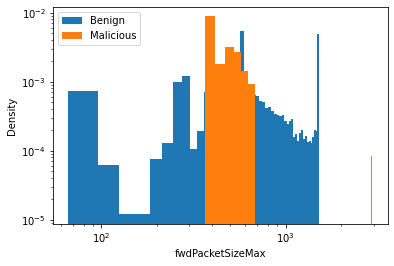

<IPython.core.display.Javascript object>

In [10]:
#feature = "fwdPacketSizeMax"
feature = "fwdPacketSizeMax"

df_benign = pd_benign
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Benign", zorder=2
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious", zorder=3
)


plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


Text(0, 0.5, 'Density')

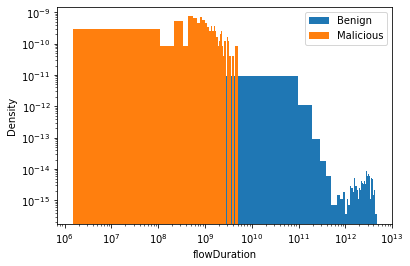

<IPython.core.display.Javascript object>

In [12]:
#feature = "flowDuration"
feature = "flowDuration"

df_benign = pd_benign
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Benign", zorder=2
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious", zorder=3
)


plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


Text(0, 0.5, 'Density')

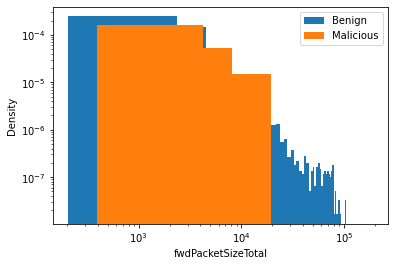

<IPython.core.display.Javascript object>

In [13]:
#feature = "fwdPacketSizeTotal"
feature = "fwdPacketSizeTotal"

df_benign = pd_benign
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Benign", zorder=2
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious", zorder=3
)


plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


Text(0, 0.5, 'Density')

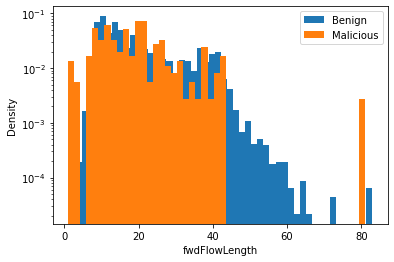

<IPython.core.display.Javascript object>

In [14]:
#feature = "fwdFlowLength"
feature = "fwdFlowLength"

df_benign = pd_benign
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Benign", zorder=2
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious", zorder=3
)


#plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


Text(0, 0.5, 'Density')

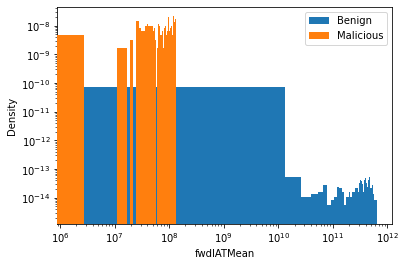

<IPython.core.display.Javascript object>

In [15]:
#feature = "fwdIATMean"
feature = "fwdIATMean"

df_benign = pd_benign
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Benign", zorder=2
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious", zorder=3
)


plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


Text(0, 0.5, 'Density')

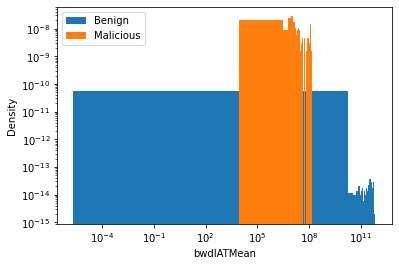

<IPython.core.display.Javascript object>

In [16]:
#feature = "bwdIATMean"
feature = "bwdIATMean"

df_benign = pd_benign
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Benign", zorder=2
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious", zorder=3
)


plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


Text(0, 0.5, 'Density')

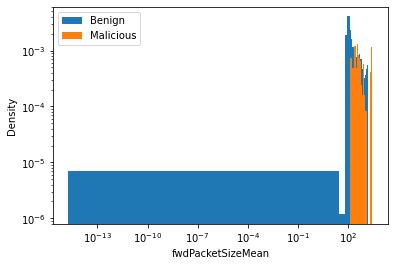

<IPython.core.display.Javascript object>

In [17]:
#feature = "fwdPacketSizeMean"
feature = "fwdPacketSizeMean"

df_benign = pd_benign
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Benign", zorder=2
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious", zorder=3
)


plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


Text(0, 0.5, 'Density')

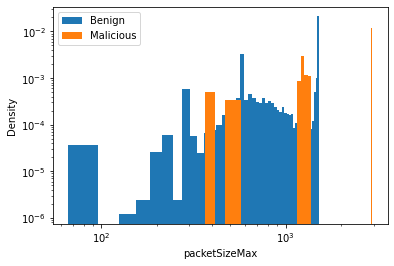

<IPython.core.display.Javascript object>

In [18]:
#feature = "packetSizeMax"
feature = "packetSizeMax"

df_benign = pd_benign
df_malicious = pd_malicious


MIN1, MAX1 = (
    df_benign[feature].min(),
    df_benign[feature].max(),
)


MIN2, MAX2 = (
    df_malicious[feature].min(),
    df_malicious[feature].max(),
)


NUM_BINS = 50

IF_NORM = True

ylabel_dict = {True: "Density", False: "Frequency"}

plt.hist(
    x=df_benign[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN1, MAX1, NUM_BINS),
    density=IF_NORM,
    label="Benign", zorder=2
)

plt.hist(
    x=df_malicious[feature].values,
    # bins=10 ** np.linspace(np.log10(MIN1), np.log10(MAX1), NUM_BINS),
    bins=np.linspace(MIN2, MAX2, NUM_BINS),
    density=IF_NORM,
    label="Malicious", zorder=3
)


plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.legend()
plt.xlabel(feature)
plt.ylabel(ylabel_dict[IF_NORM])


# Machine learning - feature importance

## Clean dataset

In [11]:
# Remove spurious entries from dataset.
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)

    df_X = df.iloc[:, :-1]
    df_Y = df.iloc[:, -1]

    print(df.shape, df_X.shape, df_Y.shape)
    indices_to_keep = ~df_X.isin([np.nan, np.inf, -np.inf]).any(1)
    return df_X[indices_to_keep].astype(np.float64).values, df_Y[indices_to_keep].values

<IPython.core.display.Javascript object>

### Get feature and class arrays (X and y.)

In [12]:
# Get feature and class arrays (X and y.)
pd_comb_features_cp = pd_comb_features.copy(deep=True)

X, y = clean_dataset(pd_comb_features_cp)

(28962, 40) (28962, 39) (28962,)


<IPython.core.display.Javascript object>

## Train test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape, X_test.shape)

(20273, 39) (8689, 39)


<IPython.core.display.Javascript object>

## Scale data

In [14]:
scaler = StandardScaler()  # MinMaxScaler
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

<IPython.core.display.Javascript object>

## Weighted Logistic Regression

### Hyperparameter grid search.

In [15]:
# Class weights.
w = [
    {0: 0.10, 1: 99.90},
    {0: 0.25, 1: 99.75},
    {0: 0.50, 1: 99.50},
    {0: 0.75, 1: 99.25},
    {0: 1.00, 1: 99.00},
    {
        0: 100
        * np.sum(y == "Malicious")
        / (np.sum(y == "Benign") + np.sum(y == "Malicious")),
        1: 100
        * np.sum(y == "Benign")
        / (np.sum(y == "Benign") + np.sum(y == "Malicious")),
    },
]

# Inverse of regularization strength.
crange = np.arange(0.1, 1.0, 0.2)


# Hyperparameter grid.
hyperparam_grid = {
    "class_weight": w,
    "penalty": ["l1", "l2"],
    "C": crange,
    "fit_intercept": [True, False],
}

<IPython.core.display.Javascript object>

### Prepare samples.

In [16]:
# String to int for classes
y_train2 = np.copy(y_train)
y_train2[np.where(y_train == "Benign")[0]] = 0
y_train2[np.where(y_train == "Malicious")[0]] = 1

<IPython.core.display.Javascript object>

### Model fitting.

In [17]:
# logistic model classifier.
lg = LogisticRegression(random_state=13)

# define evaluation procedure
grid = GridSearchCV(
    lg, hyperparam_grid, scoring="roc_auc", cv=10, n_jobs=-1, refit=True
)
grid.fit(X_train_scale, y_train2.astype("int32"))

print(f"Best score: {grid.best_score_} with param: {grid.best_params_}")

/Users/siddharthsatpathy/opt/anaconda3/lib/python3.8/site-packages/scikit_learn-1.0.dev0-py3.8-macosx-10.9-x86_64.egg/sklearn/model_selection/_search.py:890: UserWarning: One or more of the test scores are non-finite: [       nan 0.9880426         nan 0.98095783        nan 0.99057238
        nan 0.97893785        nan 0.99171251        nan 0.97658718
        nan 0.99194833        nan 0.97491777        nan 0.99202053
        nan 0.97368655        nan 0.99198866        nan 0.97435697
        nan 0.98991559        nan 0.98147736        nan 0.99206716
        nan 0.97907415        nan 0.99294926        nan 0.97651238
        nan 0.99310424        nan 0.97479531        nan 0.99329743
        nan 0.97358621        nan 0.99321499        nan 0.97423402
        nan 0.9905359         nan 0.98155072        nan 0.99265558
        nan 0.97911204        nan 0.99344045        nan 0.97649611
        nan 0.99376651        nan 0.97475562        nan 0.99400771
        nan 0.97355775        nan 0.99385109 

Best score: 0.9948004205120142 with param: {'C': 0.9000000000000001, 'class_weight': {0: 1.0, 1: 99.0}, 'fit_intercept': True, 'penalty': 'l2'}


/Users/siddharthsatpathy/opt/anaconda3/lib/python3.8/site-packages/scikit_learn-1.0.dev0-py3.8-macosx-10.9-x86_64.egg/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<IPython.core.display.Javascript object>

### Test perfomance.

In [18]:
# test
y_pred_wt = grid.predict(X_test_scale)

y_test2 = np.copy(y_test)
y_test2[np.where(y_test == "Benign")[0]] = 0
y_test2[np.where(y_test == "Malicious")[0]] = 1


# performance
conf_mat = confusion_matrix(y_test2.astype("int32"), y_pred_wt)

print(f"Accuracy Score: {accuracy_score(y_test2.astype('int32'),y_pred_wt)}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test2.astype('int32'), y_pred_wt)}")
print(f"Area Under Curve: {roc_auc_score(y_test2.astype('int32'), y_pred_wt)}")
print(
    f"Recall score (Pct of true malicious detected): {100*recall_score(y_test2.astype('int32'), y_pred_wt)}"
)
print(
    f"Data reduction: { np.round( 100.0 * conf_mat.T[1].sum() / conf_mat.sum() , 2 )} percent"
)

print(
    f"Pct malicious in data sent to console: { np.round( 100.0 * conf_mat.T[1][1] / conf_mat.T[1].sum() , 2 )} percent"
)

print("F1 score: ", f1_score(y_test2.astype("int32"), y_pred_wt, average="weighted"))

Accuracy Score: 0.9766371274024629
Confusion Matrix: 
[[8418  202]
 [   1   68]]
Area Under Curve: 0.9810366858334173
Recall score (Pct of true malicious detected): 98.55072463768117
Data reduction: 3.11 percent
Pct malicious in data sent to console: 25.19 percent
F1 score:  0.9834254890707712


<IPython.core.display.Javascript object>

### Visualization of results

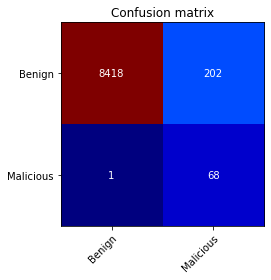

<IPython.core.display.Javascript object>

In [19]:
# Confusion matrix
xarray = ["Benign", "Malicious"]
yarray = ["Benign", "Malicious"]

conf_matrix = confusion_matrix(y_test2.astype("int32"), y_pred_wt)


fig, ax = plt.subplots()
im = ax.imshow(conf_matrix, cmap=plt.cm.jet, clim=(0, 1000))

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(xarray)))
ax.set_xticklabels(xarray)

ax.set_yticks(np.arange(len(yarray)))
ax.set_yticklabels(yarray)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(xarray)):
    for j in range(len(yarray)):
        text = ax.text(j, i, conf_matrix[i, j], ha="center", va="center", color="w")

ax.set_title("Confusion matrix")
fig.tight_layout()
plt.show()

### Best fit parameters.

In [20]:
# define model
best_fit_model = LogisticRegression(
    class_weight=grid.best_params_["class_weight"],
    penalty=grid.best_params_["penalty"],
    C=grid.best_params_["C"],
    fit_intercept=grid.best_params_["fit_intercept"],
    random_state=13,
    max_iter=5,
)

# fit it
best_fit_model.fit(X_train_scale, y_train2.astype("int32"))

/Users/siddharthsatpathy/opt/anaconda3/lib/python3.8/site-packages/scikit_learn-1.0.dev0-py3.8-macosx-10.9-x86_64.egg/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.9000000000000001, class_weight={0: 1.0, 1: 99.0},
                   max_iter=5, random_state=13)

<IPython.core.display.Javascript object>

### Save parameters.

In [30]:
np.savetxt("mean.txt", scaler.mean_, delimiter=",")
np.savetxt("std.txt", scaler.scale_, delimiter=",")
np.savetxt("weights.txt", best_fit_model.coef_[0], delimiter=",")
np.savetxt("intercept.txt", best_fit_model.intercept_, delimiter=",")

<IPython.core.display.Javascript object>

### Feature importance scores

In [21]:
important_features = pd_comb_features_cp.iloc[:, :-1].columns.values[
    np.argsort(-1 * np.abs(best_fit_model.coef_[0]))
]

<IPython.core.display.Javascript object>

In [22]:
important_features

array(['flowLength', 'bwdFlowLength', 'packetSizeMin', 'bwdPacketSizeMin',
       'bwdPacketSizeTotalPerTime', 'packetSizeTotalPerTime',
       'packetSizeMax', 'bwdPacketSizeMax', 'bwdFlowLengthPerTime',
       'flowLengthPerTime', 'bwdIATTotal', 'flowDuration', 'IATMean',
       'bwdIATMean', 'packetSizeTotal', 'bwdPacketSizeTotal', 'bwdIATStd',
       'IATStd', 'bwdPacketSizeStd', 'packetSizeStd', 'bwdIATMax',
       'IATMax', 'packetSizeMean', 'fwdPacketSizeMean',
       'bwdPacketSizeMean', 'IATMin', 'bwdIATMin',
       'fwdPacketSizeTotalPerTime', 'fwdIATStd', 'fwdPacketSizeTotal',
       'fwdIATMin', 'fwdIATMax', 'fwdPacketSizeMax', 'fwdPacketSizeMin',
       'fwdFlowLengthPerTime', 'fwdPacketSizeStd', 'fwdFlowLength',
       'fwdIATTotal', 'fwdIATMean'], dtype=object)

<IPython.core.display.Javascript object>